# Potato Blight Dusease Detection-CNN

### Import all the Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers

## Set all the Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# Initializing, Exploring & Partioning the Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",shuffle= True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size= BATCH_SIZE) 

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy().shape)

(256, 256, 3)


# Displaying Some Sample Images

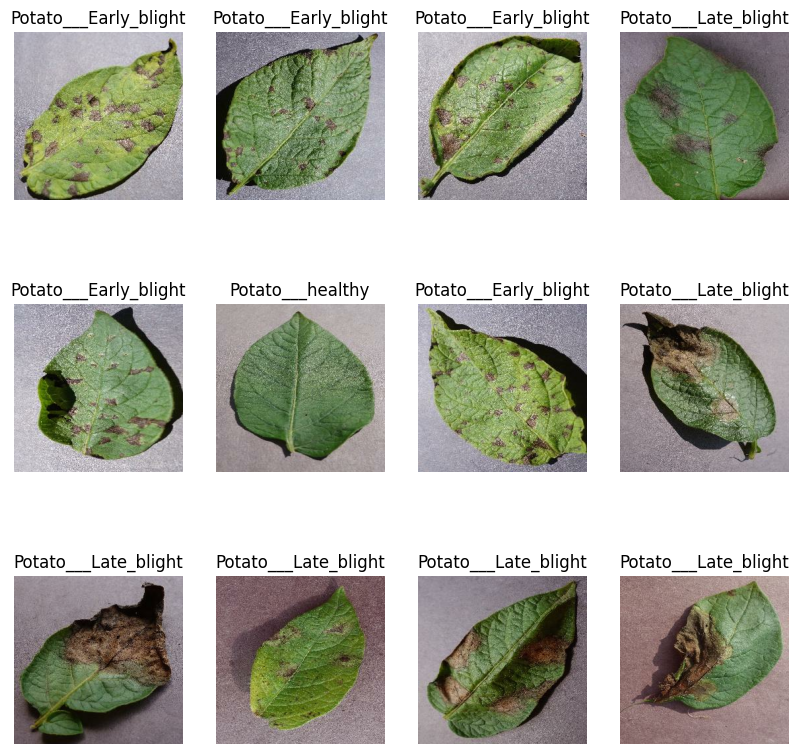

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### we take 80% for training , 10% for validation and 10% for Testing

In [10]:
train_size = 0.8
train_size*len(dataset)

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = 0.5
len(test_ds)*val_size

7.0

In [14]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [15]:
test_ds = test_ds.skip(7)
len(test_ds)

7

# Function to Split Dataset
### Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle =True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split* ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(test_ds)

8

In [20]:
len(val_ds)

6

## Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

# Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(filters = 32, kernel_size= (3,3), activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape= input_shape)

## Model Summary

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
model.compile(optimizer= 'adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy']
             )

## Training the Model

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 55s 915ms/step - accuracy: 0.4828 - loss: 0.9336 - val_accuracy: 0.6875 - val_loss: 0.7472
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 875ms/step - accuracy: 0.6644 - loss: 0.6901 - val_accuracy: 0.7344 - val_loss: 0.6064
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 886ms/step - accuracy: 0.7631 - loss: 0.5053 - val_accuracy: 0.8594 - val_loss: 0.3595
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 874ms/step - accuracy: 0.8425 - loss: 0.3656 - val_accuracy: 0.9115 - val_loss: 0.2224
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 873ms/step - accuracy: 0.9090 - loss: 0.2389 - val_accuracy: 0.8594 - val_loss: 0.3031
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 48s 896ms/step - accuracy: 0.9129 - loss: 0.2440 - val_accuracy: 0.8854 - val_loss: 0.2350
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 869ms/step - accuracy: 0.9156 - loss: 0.2023 - val_accuracy: 0.9167 - val_loss: 0.1776
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 877ms/step - accuracy: 0.9302 - loss: 0.1802 - val_accu

## Testing the Model

In [28]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9463 - loss: 0.1282


In [29]:
scores

[0.11581476777791977, 0.94921875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

## Plotting the Accuracy and Loss Curves

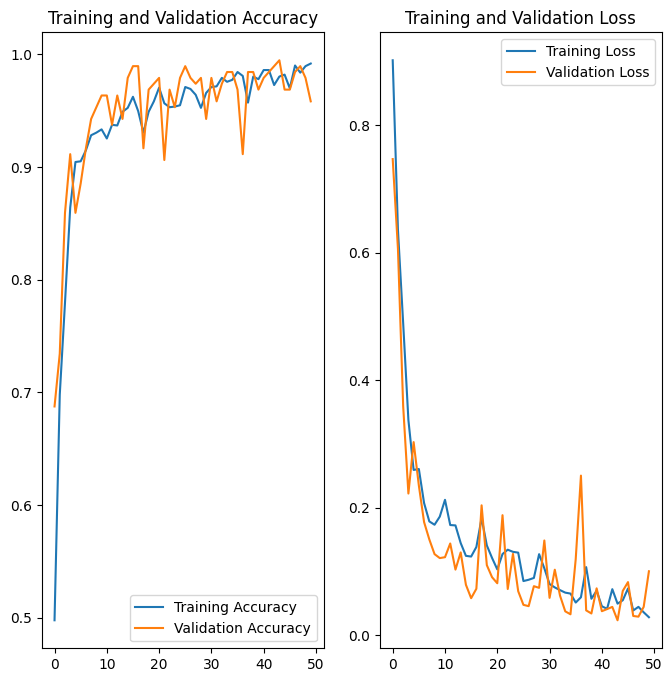

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
predicted label: Potato___Late_blight


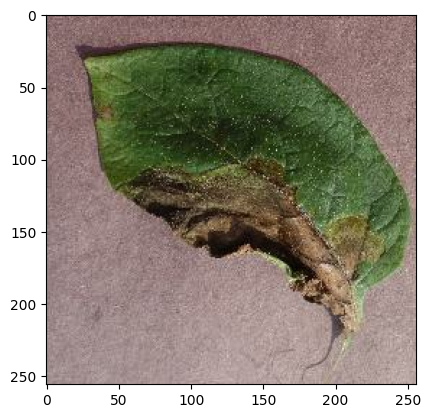

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Plotting teh Inference Data

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


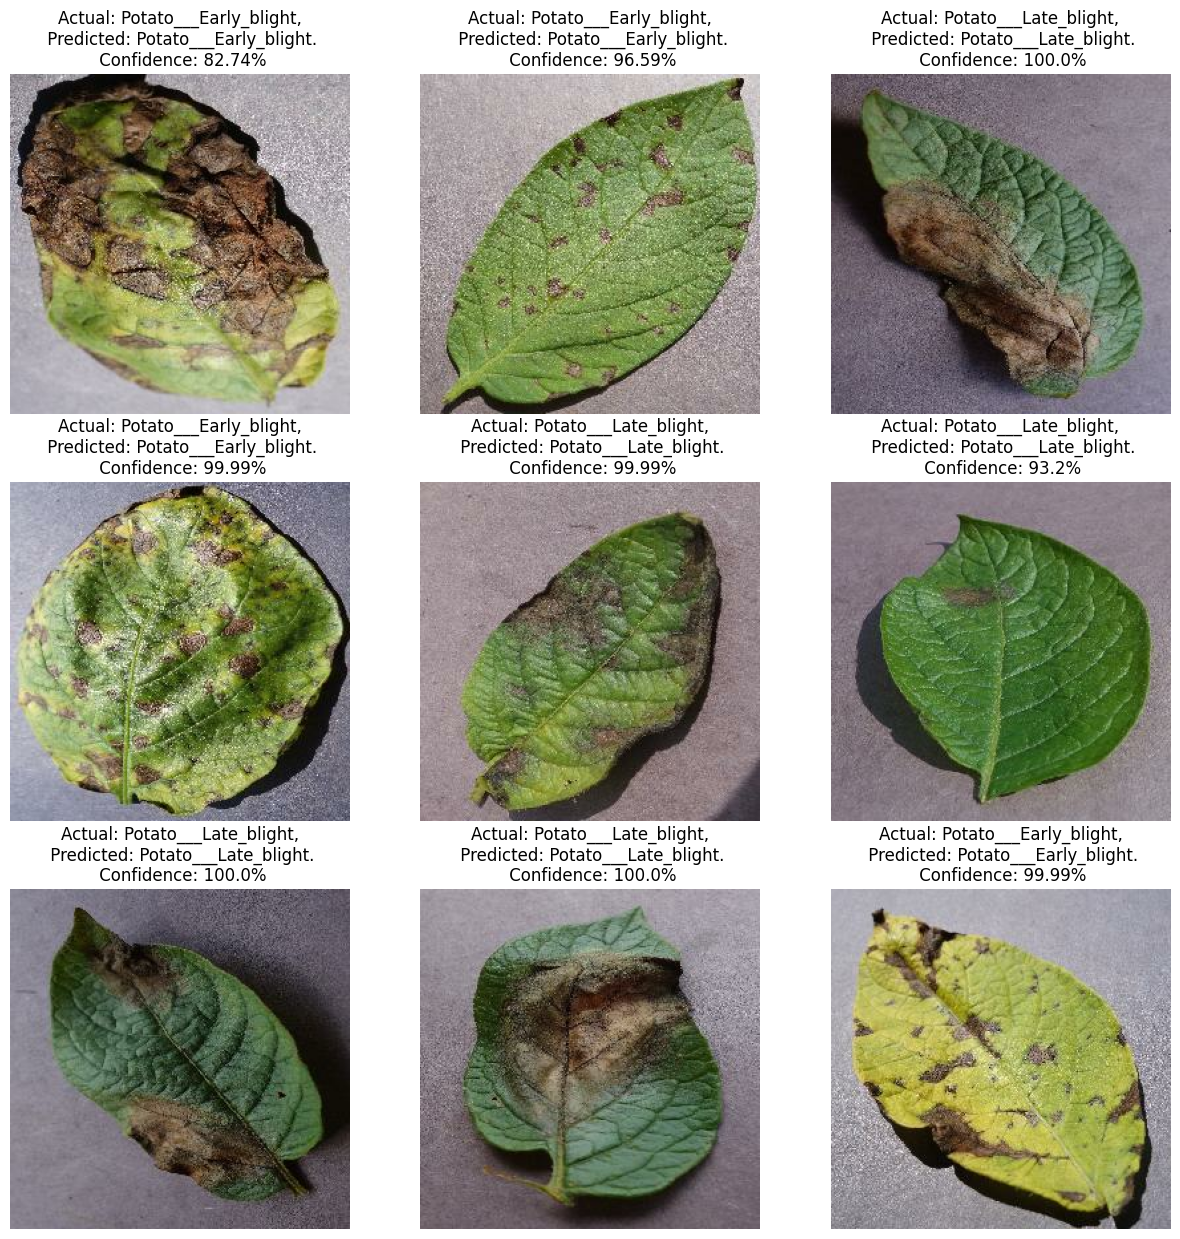

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Models in Different types

In [77]:
model.save('../saved_models/potatoes.keras')

In [79]:
model.save('../saved_models/potatoes.h5')

In [83]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models/versions") + [0]])+1
model.export(f"../saved_models/versions/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/versions/1\assets


INFO:tensorflow:Assets written to: ../saved_models/versions/1\assets


Saved artifact at '../saved_models/versions/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2094830946640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830946832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830947216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830948368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830947408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830949904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830948752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830949712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950480: TensorSpe

In [85]:
model_version=max([int(i) for i in os.listdir("../saved_models/versions") + [0]])+1
model.export(f"../saved_models/versions/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/versions/2\assets


INFO:tensorflow:Assets written to: ../saved_models/versions/2\assets


Saved artifact at '../saved_models/versions/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2094830946640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830946832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830947216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830948368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830947408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830949904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830948752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830949712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950480: TensorSpe

In [87]:
model_version=max([int(i) for i in os.listdir("../saved_models/versions") + [0]])+1
model.export(f"../saved_models/versions/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/versions/3\assets


INFO:tensorflow:Assets written to: ../saved_models/versions/3\assets


Saved artifact at '../saved_models/versions/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2094830946640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830946832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830947216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830948368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830947408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830949904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830948752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830949712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2094830950480: TensorSpe